In [1]:
import operator
import math
import random
import matplotlib.pyplot as plt

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [2]:
# Constants
ITEMS = 20
x = [random.uniform(0,1) for _ in range(ITEMS)]
y = random.sample(range(0,ITEMS), ITEMS)

In [3]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

In [4]:
def evaluate(individual, x_points, y_points):
    func = toolbox.compile(expr=individual)
    # err = (func(x) - y) for x in points
    err = []
    for i in range(ITEMS):
        x = x_points[i]
        y = y_points[i]
        err.append((func(x) - y) ** 2)
        
    return math.fsum(err) / ITEMS,

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [6]:
toolbox.register("evaluate", evaluate, x_points=x, y_points=y)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

In [7]:
def plot(candidate_function, x_points, y_points):
    my_y_points = []
    for x in x_points:
        my_y_points.append(candidate_function(x))

    plt.plot(x_points, y_points, 'b', x_points, my_y_points, 'r')
    plt.show()

In [8]:
def main():
    random.seed(318)

    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats,
                                   halloffame=hof, verbose=False)
    
    return pop, log, hof

add(protectedDiv(1, protectedDiv(cos(1), add(add(x, 1), sin(x)))), protectedDiv(1, protectedDiv(cos(1), add(add(x, 1), add(x, 1)))))


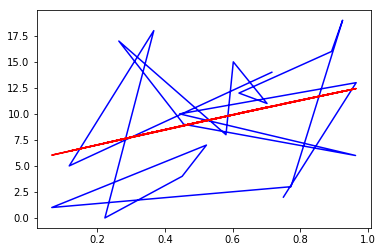

In [9]:
if __name__ == "__main__":
    results = main()
    expr = results[2][0]
    print(expr)
    # PLOTANDO OS GRAFICOS
    tree = gp.PrimitiveTree(expr)
    candidate_function = toolbox.compile(tree)
#     original_function = lambda x: x**4 + x**3 + x**2 + x
    plot(candidate_function, x, y)
    